In [152]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline



In [153]:
cosmo = ccl.Cosmology(Omega_c=(0.3156 - 0.0491685),
                                           Omega_b=0.0491685,
                                           h=0.6727,
                                           sigma8=0.831,
                                           n_s=0.9645,
                                           w0=-1,
                                           wa=0)

Text(0, 0.5, '$n(z)$')

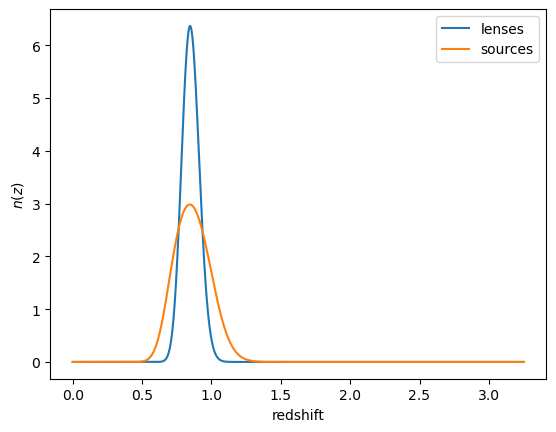

In [154]:
ells = np.geomspace(20,2000,50)
nz_source = np.load("n_source.npy")
nz_lens = np.load("n_lens.npy")

plt.plot(nz_lens[0,:],nz_lens[1,:], label = r"lenses")
plt.plot(nz_source[0,:],nz_source[1,:], label = r"sources")

plt.legend()
plt.xlabel(r"redshift")
plt.ylabel(r"$n(z)$")


Text(0, 0.5, 'weight function')

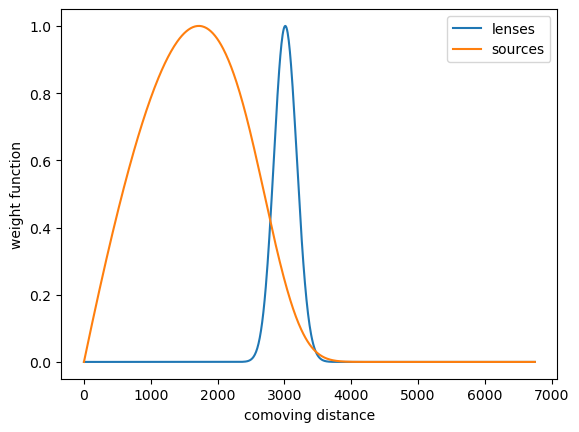

In [159]:
tracer1 = ccl.NumberCountsTracer(
                    cosmo,
                    has_rsd=False,
                    dndz=(nz_lens[0,:],nz_lens[1,:]),
                    bias=(nz_lens[0,:],np.ones_like(nz_lens[0,:]))
                )
            
tracer2 = ccl.WeakLensingTracer(
    cosmo,
    dndz=(nz_source[0,:],nz_source[1,:]), ia_bias = (nz_source[0,:], np.full_like(nz_source[0,:], 1.0)))

chi = ccl.comoving_radial_distance(cosmo, 1 / (1 + nz_lens[0,:]))

number_count_weight = tracer1.get_kernel(chi)[0]
cosmic_shear_weight = tracer2.get_kernel(chi)[0]
cosmic_shear_weight_IA = tracer2.get_kernel(chi)[1]*0.0134*0.3156


plt.plot(chi,number_count_weight/np.max(number_count_weight), label = r"lenses")
plt.plot(chi,cosmic_shear_weight/np.max(cosmic_shear_weight), label = r"sources")


plt.legend()
plt.xlabel(r"comoving distance")
plt.ylabel(r"weight function")



WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error


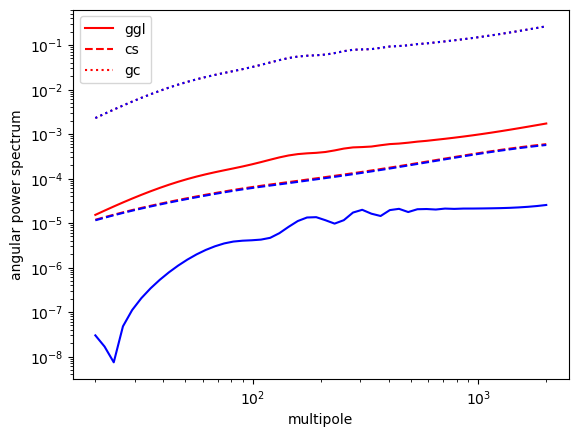

In [162]:

cl_ggl_values = ccl.angular_cl(cosmo, tracer1, tracer2, ells)
cl_cs_values = ccl.angular_cl(cosmo, tracer2, tracer2, ells)
cl_gc_values = ccl.angular_cl(cosmo, tracer1, tracer1, ells)
cl_ggl_values_check = np.zeros_like(cl_values)
cl_cs_values_check = np.zeros_like(cl_values)
cl_gc_values_check = np.zeros_like(cl_values)

chi_int = np.geomspace(1, chi[-1], int(1e3))
a_of_chi = UnivariateSpline(chi, 1./(1.+ nz_lens[0,:]), k = 3, s =0, ext=0)
w_lens = UnivariateSpline(chi, number_count_weight, k = 3, s =0, ext=0)
w_source = UnivariateSpline(chi, cosmic_shear_weight + cosmic_shear_weight_IA, k = 3, s =0, ext=0)

w_lens = w_lens(chi_int)
w_source = w_source(chi_int)
a = a_of_chi(chi_int)

for i_ell in range(len(ells)):
    integrand = np.diag(ccl.nonlin_matter_power(cosmo, (ells[i_ell] + .5)/chi_int, a))
    cl_ggl_values_check[i_ell] = np.trapz(w_source*w_lens/chi_int**2*integrand, chi_int)
    cl_cs_values_check[i_ell] = np.trapz(w_source*w_source/chi_int**2*integrand, chi_int)
    cl_gc_values_check[i_ell] = np.trapz(w_lens*w_lens/chi_int**2*integrand, chi_int)

plt.loglog(ells,ells**2*np.abs(cl_ggl_values_check),  color = "red", label = "ggl", ls = "-")
plt.loglog(ells,ells**2*np.abs(cl_ggl_values), color = "blue", ls = "-")
plt.loglog(ells,ells**2*np.abs(cl_cs_values_check),  color = "red", label = "cs", ls = "--")
plt.loglog(ells,ells**2*np.abs(cl_cs_values), color = "blue", ls = "--")
plt.loglog(ells,ells**2*np.abs(cl_gc_values_check),  color = "red", label = "gc", ls = ":")
plt.loglog(ells,ells**2*np.abs(cl_gc_values_check), color = "blue", ls = ":")

plt.xlabel(r"multipole")
plt.ylabel(r"angular power spectrum")
plt.legend()
